# Model for single mode squeezed vacuum and squeezed coherent state

We test the boson sampling operator (no training) 
on coherent states and squeezed states

We compare with theory

nonlinearxwaves@gmail.com<br>
@version 28 january 2021<br>
@version 3 may 2023<br

In [2]:
import numpy as np
import math
from thqml import phasespace as ps
import tensorflow as tf
import matplotlib.pyplot as plt

2023-05-03 18:39:46.055231: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-03 18:39:46.055249: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float64

In [4]:
tf.keras.backend.clear_session()

In [5]:
np.set_printoptions(precision=2)

Check GPU

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


2023-05-03 18:39:55.874533: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-03 18:39:55.874567: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-03 18:39:55.874595: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x1): /proc/driver/nvidia/version does not exist


## Dimension

In [7]:
N = 4

In [8]:
n=np.floor_divide(N,2)

## Build vacuum by the Gaussian state

In [9]:
vacuum = ps.VacuumLayer(N)

2023-05-03 18:40:00.936986: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Squeezer for mode 0

In [10]:
r_np=0.8;
theta_np=np.pi/4;
squeezer=ps.SingleModeSqueezerLayer(N, r_np=r_np, theta_np=theta_np, n_squeezed=0)

## Displacer for mode 1

Define the alpha vector for the alpha

In [11]:
alpha=np.zeros([2],dtype=np_complex)

In [12]:
alpha[0]=0
alpha[1]=1.5
print(alpha)
print(np.abs(alpha)**2)

[0. +0.j 1.5+0.j]
[0.   2.25]


Define the corresponding displacement vector

In [13]:
dinput_np=np.zeros([N,1], dtype=np_real)
for j in range(n):
    dinput_np[2*j]=np.sqrt(2)*np.real(alpha[j])
    dinput_np[2*j+1]=np.sqrt(2)*np.imag(alpha[j])

In [14]:
dinput = tf.constant( dinput_np, dtype=vacuum.dtype)
displacer = ps.DisplacementLayerConstant(dinput)

## Build the model

In [15]:
xin = tf.keras.layers.Input(N)
x1, a1 = displacer(xin)
x2, a2 = squeezer(x1, a1)
chir, chii = vacuum(x2, a2)
model = tf.keras.Model(inputs = xin, outputs=[chir, chii])

# Evaluate the covariance

In [16]:
cov_layer = ps.CovarianceLayer(N)
covariance_matrix, mean_R, hessian = cov_layer(chir,chii, model)
squeezed_cov = tf.keras.Model(inputs = xin, outputs=[covariance_matrix, mean_R, hessian])
xtrain = np.random.rand(1, N)-0.5
cov0,d0, hessian0=squeezed_cov(xtrain); print(d0); tf.print(cov0)

tf.Tensor([[0.   0.   2.12 0.  ]], shape=(1, 4), dtype=float32)
[[0.897684276 -1.67978024 -0 -0]
 [-1.67978024 4.25724459 -0 -0]
 [-0 -0 1 -0]
 [-0 -0 -0 1]]


# Evaluate the Qtransform with calculated covariance and displacemente

In [17]:
Qrho = ps.QTransform(cov0, d0)

# Test the Pr operator 

Probability of zero photon

In [18]:
ps.Pr([0,0], Qrho)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.08]], dtype=float32)>

Probability of two photons

In [21]:
%%time
ps.Pr([0,2], Qrho)

CPU times: user 89.1 ms, sys: 388 µs, total: 89.5 ms
Wall time: 88.5 ms


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>

## Define a function with the expected theoretical value

In [22]:
def Psqueeze(n, r):
    # returh the theory value for the Boson sampling for coherent states
    
    scale = 1.0
    if n % 2 ==0 :
        scale = scale/np.cosh(r)
        scale = scale*np.power(np.tanh(r), n)
        scale = scale*np.math.factorial(n)
        scale = scale/np.power(2.0,n)
        n2 = n/2
        scale = scale/np.power(np.math.factorial(n2),2)
    else:
        scale = 0.0
    
    return scale 

def Pcoherent(nj, alpha):
    # returh the theory value for photon distribution in a coherent state
    
    scale = 1

    aj2 = np.abs(alpha)**2
    scale = scale/np.math.factorial(nj)
    scale = scale*np.exp(-aj2)*np.power(aj2,nj)
    
    return scale 

def theoryPr(nbar, alpha):
    # returh the theory value for the Boson sampling for 
    # one coherent state (mode 1) and one squeezed (mode 0)
    n0=nbar[0]
    n1=nbar[1]
    
    P0=Psqueeze(n0, r_np)
    P1=Pcoherent(n1,alpha[1])
    
    return P0*P1  

## Compare with some examples

In [23]:
nbar=[0,0]
tf.print(ps.Pr(nbar, Qrho))
print(theoryPr(nbar,alpha))

[[0.0788070112]]
0.07880699158719338


In [24]:
nbar=[1,0]
tf.print(ps.Pr(nbar, Qrho))
print(theoryPr(nbar,alpha))

[0]
0.0


In [25]:
nbar=[1,1]
tf.print(ps.Pr(nbar, Qrho))
print(theoryPr(nbar,alpha))

[-1.86264515e-09]
0.0


In [27]:
%%time
nbar=[2,3]
tf.print(ps.Pr(nbar, Qrho))
print(theoryPr(nbar,alpha))

[0.0329849236]
0.03298491082783896
CPU times: user 20.1 s, sys: 9.95 ms, total: 20.1 s
Wall time: 20.1 s


## Make a plot versus the probability

Build an array of photon number sampling

In [28]:
%%time
nmax=3 # max number of photons
# generate the combinations
import itertools as it
nlist=it.product(range(nmax+1),repeat=n)
ln=list(nlist)
print(ln)
print(len(ln))

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]
16
CPU times: user 116 µs, sys: 4 µs, total: 120 µs
Wall time: 112 µs


In [29]:
%%time
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Computing Pn at n '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    Pth[nbar]=theoryPr(ln[nbar],alpha)
    print(Pth[nbar])
    xaxis[nbar]=nbar
print('Done')

Computing Pn at n (0, 0)
0.07880701
0.07880699
Computing Pn at n (0, 1)
0.17731574
0.17731573
Computing Pn at n (0, 2)
0.19948022
0.19948019
Computing Pn at n (0, 3)
0.14961013
0.14961015
Computing Pn at n (1, 0)
0.0
0.0
Computing Pn at n (1, 1)
-1.8626451e-09
0.0
Computing Pn at n (1, 2)
-6.519258e-09
0.0
Computing Pn at n (1, 3)
6.2284045e-09
0.0
Computing Pn at n (2, 0)
0.017374773
0.017374767
Computing Pn at n (2, 1)
0.039093237
0.039093226
Computing Pn at n (2, 2)
0.04397989
0.04397988
Computing Pn at n (2, 3)
0.032984924
0.032984912
Computing Pn at n (3, 0)
7.14014e-09
0.0
Computing Pn at n (3, 1)
1.46683306e-08
0.0
Computing Pn at n (3, 2)
3.170134e-09
0.0
Computing Pn at n (3, 3)
-9.931893e-10
0.0
Done
CPU times: user 4min 21s, sys: 1.17 s, total: 4min 22s
Wall time: 4min 22s


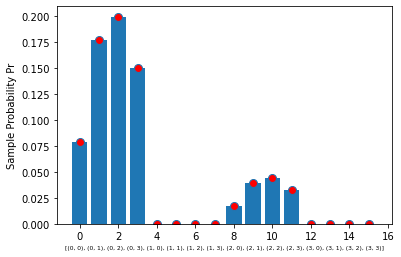

In [30]:
plt.bar(xaxis,Pn)
plt.plot(xaxis, Pth, marker='o', markersize=8, markerfacecolor='red', linestyle='none')
plt.xlabel(ln, fontsize=6);
plt.ylabel('Sample Probability Pr');
plt.savefig('BosonSamplingExample4.pdf', format='pdf')

Comparison between the photon number evaluated with the model(bars) and the theory (red dots). Sampling patters are indicate in the labels.